## 计算机模拟 HW2

**汪奕晨 3180105843**

### 问题重述
用以下三种方式产生正态分布随机数列，并分析比较它们的抽取效率和随机数质量：

1. 用拒绝接受法产生半正态分布，再变换为正态分布；

2. 用 Hasting 提供的逆映射有理逼近直接抽取；

3. 通过重复伯努利实验逼近正态分布，n 取 12.

直接在 Jupyer-Notebook 中完成你的作业，要求包含问题描述、必要的测试代码、结果分析、和结论。总字数不得超过2000字，总代码不得超过500行。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### 通过不同方法抽取给定数量的随机数

#### 方法1  AR方法

若$X \thicksim \mathcal{N}(\mu,\sigma^2)$,则令$Y = \frac{X-\mu}{\sigma}$,$Y \thicksim \mathcal{N}(0,1)$则我们只需要考虑标准的情况，然后通过一个线性的变换就可以得到任意参数的正态分布了，故不妨设$X$满足标准正态分布

$$p(x) = \frac{1}{\sqrt{2\pi}}e^{-x^2/2}, x \in \mathbb{R}$$

对于半正态分布，考虑$Y = |X|$

$$p(y) = \sqrt{\frac{2}{\pi}}e^{-y^2/2} = \sqrt{\frac{2e}{\pi}}e^{-(y-1)^2/2}e^{-y} ,y \in [0,+\infty)$$

$h(y) = e^{-y}, H(y) = \int_0^yh(t)\mathrm{d}t = 1 - e^{-y}, H^{-1}(u) = -\ln(1-u)$

简化代码的技巧：

+ 使用numpy中的array而非python中原生的list，通过np中的向量化函数可以更好的简化逻辑
+ 可以用向量化的比较得到布尔值数组，通过布尔值索引可以迅速得到被accept的抽取值

In [3]:
def halfnorm_rand(n):
    U = np.random.rand(n)
    # H = np.array([-np.log(1-u) for u in U]) # 也可以直接计算-np.log(u),这是由于u符合[0,1]均匀分布时，1-u也符合[0,1]均匀分布
    H = -np.log(1-U)
    # G = np.array([np.exp(-(h-1)**2/2) for h in H]) # g(x)
    G = np.exp(-(H-1)**2/2)
    U = np.random.rand(n) # 这次产生的均匀分布是为了检验拒绝/接受
    cp = U < G
    accept = cp.sum()
    Y = H[cp]
    return accept, Y

1.3165516878192638
1.315489246958914


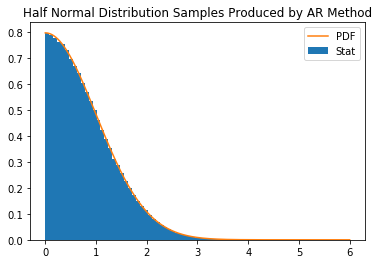

In [5]:
n1 = 1000000  # 生成随机数的数据量
k1,X1 = halfnorm_rand(n1)
print(n1/k1)
print((2*np.e/np.pi)**0.5)
x = np.linspace(0,6,10000)
plt.hist(X1, bins=64, normed=True, label=r"Stat");
plt.plot(x,np.sqrt(2/np.pi)*np.exp(-x**2/2), label=r"PDF")
plt.legend()
plt.title(r"Half Normal Distribution Samples Produced by AR Method")
# plt.savefig('half_normal.pdf')
plt.show()

接下来我们需要将半正态分布改造为正态分布，只需要在抽取每个值后通过一次随机数判断是否需要取相反数即可。
在这里仍然可以使用逻辑值索引的优化方法。

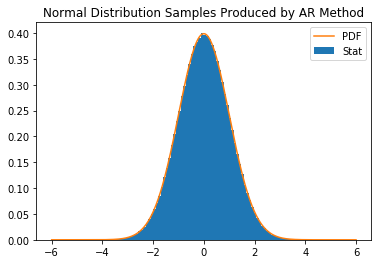

In [7]:
# 改造为标准正态分布
U = np.random.rand(k1)
s = U<0.5
X1[s] = -X1[s]
x = np.linspace(-6,6,20000)
plt.hist(X1, bins=100, normed=True, label=r"Stat");
plt.plot(x,np.sqrt(1/2/np.pi)*np.exp(-x**2/2), label=r"PDF")
plt.legend()
plt.title(r"Normal Distribution Samples Produced by AR Method")
# plt.savefig('half_normal.pdf')
plt.show()

#### 方法2 有理逼近

给出的有理逼近式如下
$$
F^{-1}(y) = \mu +
\mathrm{sign}(y - \frac{1}{2})\sigma\left(t - 
\frac{c_0 + c_1 t + c_2 t^2}{1 + d_1 t + d_2 t^2 + d_3 t^3}\right),
$$

$$
t = \sqrt{-\ln[\min(y,1-y)^2]}
$$

仍旧考虑$\mu = 0,\sigma = 1$的标准正态分布。通过np中的minimum,sign等函数得到有理逼近的结果

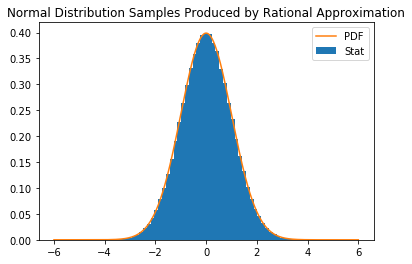

In [9]:
mu = 0
sigma = 1
# parameters
c0=2.515517;c1=0.802853;c2=0.010328;d1=1.432788;d2=0.189269;d3=0.001308
# 蒙特卡罗
Y = np.random.rand(n1)
T = (-np.log(np.minimum(Y,1-Y)**2))**0.5
X2 = mu + np.sign(Y-1/2) * sigma * (T - (c0 + c1*T + c2*T**2) / (1 + d1*T + d2*T**2 + d3*T**3))

x = np.linspace(-6,6,20000)
plt.hist(X2, bins=64, normed=True, label=r"Stat");
plt.plot(x,np.sqrt(1/2/np.pi)*np.exp(-x**2/2), label=r"PDF")
plt.legend()
plt.title(r"Normal Distribution Samples Produced by Rational Approximation")
# plt.savefig('half_normal.pdf')
plt.show()


#### 方法3 多次伯努利实验逼近正态分布

令$X_i \thicksim (-1/2,1/2)$,$Z_n = \sqrt{12/n}(X_1+ X_2 + \cdots + X_n)$

由中心极限定理:$Z_n \thicksim \mathcal{N}(0,1), n \rightarrow \infty$

In [10]:
def norm_m3_rand_one(n=12):
    # n为模型中的n,根据作业要求默认为12
    X = np.random.rand(n) - 0.5
    return X.sum()*(12/n)**0.5


def norm_m3_rand(m,n=12):
    # n为模型中的n，默认为12
    # m为生成的数据量
    X = np.array([norm_m3_rand_one(n) for i in range(m)])
    return X

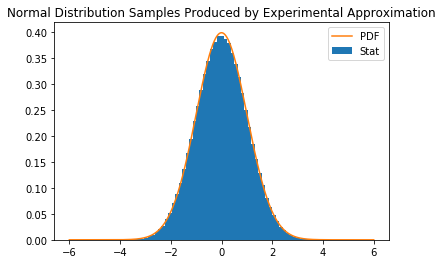

In [14]:
# n,m = 1000,10000
X3 = norm_m3_rand(n1)

x = np.linspace(-6,6,20000)
plt.hist(X3, bins=64, normed=True, label=r"Stat");
plt.plot(x,np.sqrt(1/2/np.pi)*np.exp(-x**2/2), label=r"PDF")
plt.legend()
plt.title(r"Normal Distribution Samples Produced by Experimental Approximation")
# plt.savefig('half_normal.pdf')
plt.show()


#### 方法4

$U \thicksim U(0,1),V \thicksim E(1)(指数分布)$
则$X = \sqrt{2V}\cos(2\pi U), Y = \sqrt{2V}\sin(2\pi U)$符合标准正态分布

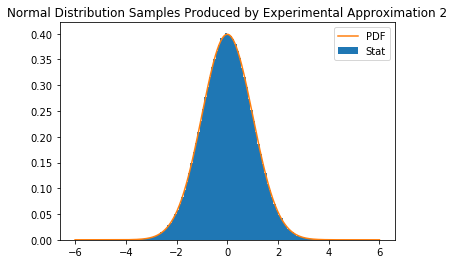

In [13]:
# n = 100000
U = np.random.rand(n1)
V = stats.expon.rvs(loc=0, scale=1, size=n1)
X4 = (2*V)**0.5 * np.cos(2*np.pi*U)
Y4 = (2*V)**0.5 * np.sin(2*np.pi*U)
x = np.linspace(-6,6,20000)
plt.hist(X4, bins=100, normed=True, label=r"Stat");
plt.plot(x,np.sqrt(1/2/np.pi)*np.exp(-x**2/2), label=r"PDF")
plt.legend()
plt.title(r"Normal Distribution Samples Produced by Experimental Approximation 2")
# plt.savefig('half_normal.pdf')
plt.show()


### 评价生成随机数的质量

通过stats模块中的W检验，K-S检验，normaltest模块进行检验，返回的第二个值为P值，越接近1则认为更符合正态分布

In [16]:
print(stats.shapiro(X1))
print(stats.shapiro(X2))
print(stats.shapiro(X3))
print(stats.shapiro(X4))

(1.0000147819519043, 1.0)
(1.0003353357315063, 1.0)
(1.0001111030578613, 1.0)
(1.000321388244629, 1.0)


In [19]:
print(stats.kstest(X1, 'norm'))
print(stats.kstest(X2, 'norm'))
print(stats.kstest(X3, 'norm'))
print(stats.kstest(X4, 'norm'))

KstestResult(statistic=0.0007175877322286306, pvalue=0.8289765640249682)
KstestResult(statistic=0.0007579733516367426, pvalue=0.6137612864488606)
KstestResult(statistic=0.003098697651237936, pvalue=9.139071098418293e-09)
KstestResult(statistic=0.0005550362062241021, pvalue=0.9176694623370446)


In [21]:
print(stats.normaltest(X1))
print(stats.normaltest(X2))
print(stats.normaltest(X3))
print(stats.normaltest(X4))

NormaltestResult(statistic=2.8947980269766354, pvalue=0.23518119638687998)
NormaltestResult(statistic=6.9146897162885415, pvalue=0.03151332337956135)
NormaltestResult(statistic=486.6609147879798, pvalue=2.1034155237280541e-106)
NormaltestResult(statistic=2.640509547401694, pvalue=0.2670672515854334)


根据结果可以看出，在W检验中都比较显著，但kstest和normaltest给出的结果均显示四种方法中
方法四 > 方法一 >> 方法二 >> 方法三

在这里方法三表现不好可能是由于模型中$n=12$过小，但由于增大$n$会极大地增大运算量，这里不做更多的尝试了


### 结论
生成正态分布的方法有很多种.在本例的四个方法中方法一和方法四都能够给出较为良好的正态分布，并且有可接受的运行速度。而方法二（有理逼近）有更快的速度，但在数据的质量上显著低于前述两种方法，在对速度有较高需求而对质量需求不高的场景可以使用该方法。方法三在运行速度和生成质量上都远远比不上另外三种方法，故在实际应用中不建议使用，但可以用来验证中心极限定理与大数定律。